In [1]:
!pip install ultralytics > /dev/null 2>&1

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from pathlib import Path
from collections import defaultdict
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import Polygon
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
IMAGES_DIR = Path('/kaggle/input/gazpromtestdata/res_data/images/test_check')
MASKS_DIR = Path('/kaggle/input/gazpromtestdata/res_data/labels/test_check')

TEST = Path('/kaggle/input/gazpromtestdata/res_data/images/test')

OUTPUT_TEST_CHECK = Path('/kaggle/working/test_check')
OUTPUT_TEST = Path('/kaggle/working/test')

In [4]:
(OUTPUT_TEST_CHECK).mkdir(parents=True, exist_ok=True)
(OUTPUT_TEST).mkdir(parents=True, exist_ok=True)

In [5]:
SUB_IMAGE_WIDTH = 1140
SUB_IMAGE_HEIGHT = 1152

In [6]:
def split_image_only(image_path, out_img_dir):
    image = cv2.imread(str(image_path))
    img_h, img_w = image.shape[:2]
    nx, ny = img_w // SUB_IMAGE_WIDTH, img_h // SUB_IMAGE_HEIGHT

    for i in range(ny):
        for j in range(nx):
            x0, x1 = j * SUB_IMAGE_WIDTH, (j + 1) * SUB_IMAGE_WIDTH
            y0, y1 = i * SUB_IMAGE_HEIGHT, (i + 1) * SUB_IMAGE_HEIGHT

            sub_img = image[y0:y1, x0:x1]
            name = f"{image_path.stem}_{i}_{j}.png"
            cv2.imwrite(str(out_img_dir / name), sub_img)

In [7]:
image_files = list(IMAGES_DIR.rglob('*.png'))
print(f'Найдено {len(image_files)} изображений.')

Найдено 30 изображений.


In [8]:
for img_path in image_files:
    split_image_only(img_path, OUTPUT_TEST_CHECK)

In [9]:
model = YOLO('/kaggle/input/resultmodel2/runs/segment/train/weights/best.pt')  # загрузка модели

output_dir = Path('/kaggle/working/test_preds')

# Запуск инференса
results = model.predict(
    source=OUTPUT_TEST_CHECK,
    # conf=0.05, # стандарт 0.25
    save=False, # img
    save_txt=True,
    save_conf=False, # Вероятность
    name=output_dir,
    exist_ok=True
)


image 1/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_0.png: 1152x1152 1 пора, 1002.0ms
image 2/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_1.png: 1152x1152 (no detections), 715.1ms
image 3/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_10.png: 1152x1152 1 подрез, 1 эталон1, 657.0ms
image 4/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_11.png: 1152x1152 (no detections), 609.5ms
image 5/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_12.png: 1152x1152 1 эталон2, 636.9ms
image 6/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_13.png: 1152x1152 (no detections), 593.8ms
image 7/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_14.png: 1152x1152 (no detections), 719.4ms
image 8/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_15.png: 1152x1152 (no detections), 719.2ms
image 9/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_16.png: 1152x1152 2 пораs, 637.6ms
image 10/840 /kaggle/working/test_check/0-360-ls-r1-1-31he_0_17.png: 1152x1152 4 пораs, 1 эт

In [10]:
labels_dir = Path('/kaggle/working/test_preds/labels')
merged_labels_dir = Path('/kaggle/working/merged_labels')
merged_labels_dir.mkdir(exist_ok=True, parents=True)

# Размеры саб-изображений (квадраты)
SUB_IMAGE_WIDTH = 1140
SUB_IMAGE_HEIGHT = 1152

# Размер полного изображения
full_width = 31920
full_height = 1152

# Словарь для хранения меток по оригинальным изображениям
merged = {}

for label_path in labels_dir.glob('*.txt'):
    name_parts = label_path.stem.rsplit('_', 2)
    if len(name_parts) != 3:
        print(f"⚠️ Неверный формат имени: {label_path.name}")
        continue

    base_name, i, j = name_parts[0], int(name_parts[1]), int(name_parts[2])
    dx = j * SUB_IMAGE_WIDTH
    dy = i * SUB_IMAGE_HEIGHT

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 3 or (len(parts) - 1) % 2 != 0:
            print(f"⚠️ Пропускаю строку в {label_path.name}: {line.strip()}")
            continue

        cls = parts[0]
        coords = list(map(float, parts[1:]))

        global_coords = []
        for idx in range(0, len(coords), 2):
            x = coords[idx] * SUB_IMAGE_WIDTH + dx
            y = coords[idx + 1] * SUB_IMAGE_HEIGHT + dy
            global_coords.append(x / full_width)
            global_coords.append(y / full_height)

        line_out = f"{cls} " + " ".join(f"{c:.6f}" for c in global_coords) + "\n"
        merged.setdefault(base_name, []).append(line_out)

# Сохраняем объединённые метки
for base_name, lines in merged.items():
    out_path = merged_labels_dir / f"{base_name}.txt"
    with open(out_path, 'w') as f:
        f.writelines(lines)

print("✅ Объединение завершено.")

✅ Объединение завершено.


Дальше не нужно!!!!!!!!!!!!


In [11]:
from pathlib import Path
from shapely.geometry import Polygon

def read_polygons_from_txt(path, img_width, img_height):
    polygons = []
    classes = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 3:
                continue
            cls = int(parts[0])
            coords_norm = list(map(float, parts[1:]))

            # Проверка на четность координат
            if len(coords_norm) % 2 != 0:
                print(f"⚠️ Нечётное количество координат в {path.name}")
                continue

            # Переводим в абсолютные координаты
            coords_abs = []
            for i in range(0, len(coords_norm), 2):
                x = coords_norm[i] * img_width
                y = coords_norm[i+1] * img_height
                coords_abs.append((x, y))

            # Создаем полигон
            poly = Polygon(coords_abs)
            if not poly.is_valid:
                poly = poly.buffer(0)  # пытаемся исправить

            polygons.append(poly)
            classes.append(cls)
    return polygons, classes

In [12]:
def iou_poly(poly1, poly2):
    if not poly1.is_valid or not poly2.is_valid:
        return 0
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    if union == 0:
        return 0
    return inter / union

def evaluate_polygons(gt_polygons, pred_polygons, iou_threshold=0.5): # change
    matched_gt = set()
    matched_pred = set()
    for i, gt_poly in enumerate(gt_polygons):
        for j, pred_poly in enumerate(pred_polygons):
            if j in matched_pred:
                continue
            if iou_poly(gt_poly, pred_poly) >= iou_threshold:
                matched_gt.add(i)
                matched_pred.add(j)
                break
    TP = len(matched_gt)
    FP = len(pred_polygons) - len(matched_pred)
    FN = len(gt_polygons) - len(matched_gt)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

In [13]:
gt_dir = Path('/kaggle/input/gazpromtestdata/res_data/labels/test_check')  # ground truth
pred_dir = Path('/kaggle/working/merged_labels')  # предсказания

img_width = 31920
img_height = 1152

confusion_counts = defaultdict(lambda: defaultdict(int))  # confusion_counts[gt][pred]

all_precisions, all_recalls, all_f1s = [], [], []
class_stats = defaultdict(lambda: {'TP': 0, 'FP': 0, 'FN': 0, 'IoUs': []})

for gt_file in gt_dir.glob('*.txt'):
    pred_file = pred_dir / gt_file.name
    if not pred_file.exists():
        print(f"⚠️ Нет предсказания для {gt_file.name}")
        continue

    gt_polys, gt_classes = read_polygons_from_txt(gt_file, img_width, img_height)
    pred_polys, pred_classes = read_polygons_from_txt(pred_file, img_width, img_height)

    # F1 на всё изображение
    precision, recall, f1 = evaluate_polygons(gt_polys, pred_polys)
    print(f"{gt_file.name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

    # AP по классам (для mAP)
    gt_matched = set()
    pred_matched = set()

    for j, (pred_poly, pred_cls) in enumerate(zip(pred_polys, pred_classes)):
        matched = False
        for i, (gt_poly, gt_cls) in enumerate(zip(gt_polys, gt_classes)):
            if i in gt_matched or gt_cls != pred_cls:
                continue
            if iou_poly(gt_poly, pred_poly) >= 0.5:
                class_stats[pred_cls]['TP'] += 1
                gt_matched.add(i)
                pred_matched.add(j)
                matched = True
                
                iou = iou_poly(gt_poly, pred_poly)
                class_stats[pred_cls]['IoUs'].append(iou)

                confusion_counts[gt_cls][pred_cls] += 1
                break
        if not matched:
            class_stats[pred_cls]['FP'] += 1
            
            confusion_counts['background'][pred_cls] += 1
    for i, gt_cls in enumerate(gt_classes):
        if i not in gt_matched:
            class_stats[gt_cls]['FN'] += 1
            confusion_counts[gt_cls]['background'] += 1

# Средние метрики по изображениям
if all_f1s:
    print("\n📊 Средние метрики по изображениям:")
    print(f"Precision: {sum(all_precisions)/len(all_precisions):.3f}")
    print(f"Recall:    {sum(all_recalls)/len(all_recalls):.3f}")
    print(f"F1 Score:  {sum(all_f1s)/len(all_f1s):.3f}")
else:
    print("❌ Нет валидных изображений для оценки.")

13-250-ls-34-g01.txt: Precision=0.615, Recall=0.276, F1=0.381
2430-b1-14-h01.txt: Precision=0.684, Recall=0.228, F1=0.342
9-400-ls-34-b-01.txt: Precision=0.615, Recall=0.211, F1=0.314
1830-b1-14-h01.txt: Precision=0.500, Recall=0.160, F1=0.242
1040-b1-14-d01.txt: Precision=0.143, Recall=0.154, F1=0.148
9-200-ls-34-b-01.txt: Precision=0.800, Recall=0.211, F1=0.333
sod88-ls-1-059komcs.txt: Precision=0.700, Recall=0.636, F1=0.667
14-268-ls-34-g01.txt: Precision=0.630, Recall=0.207, F1=0.312
9-240-ls-34-b-01.txt: Precision=0.533, Recall=0.211, F1=0.302
sod60-ls-1-1939-1se9.txt: Precision=0.250, Recall=0.300, F1=0.273
15-180-ls-34-g01.txt: Precision=0.714, Recall=0.179, F1=0.286
830-b1-14-d01.txt: Precision=0.600, Recall=0.184, F1=0.281
0-360-ls-r1-1-31he.txt: Precision=0.783, Recall=0.327, F1=0.462
19-100-ls-34-v01.txt: Precision=0.778, Recall=0.583, F1=0.667
0-760-ls-r3-31he.txt: Precision=0.364, Recall=0.154, F1=0.216
2280-b1-14-h01.txt: Precision=0.458, Recall=0.208, F1=0.286
14-245-ls-

50 эпох: 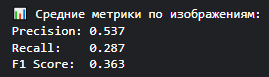

50 эпох уверенность 0.1: 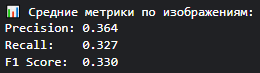

50 эпох уверенность 0.01: 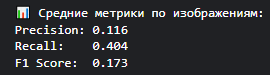

115 эпох: 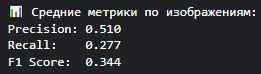

115 эпох уверенность 0.1: 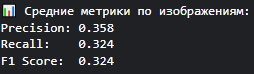

115 эпох + 20: 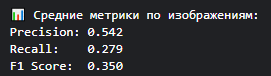

115 эпох + 20 уверенность 0.1: 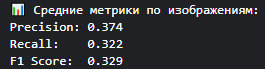

115 + контраст 13: 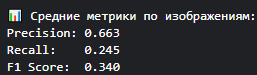

In [14]:
print("\n📌 AP по классам (IoU ≥ 0.5):")
aps = []
for cls, stats in class_stats.items():
    TP, FP, FN = stats['TP'], stats['FP'], stats['FN']
    prec = TP / (TP + FP) if TP + FP > 0 else 0
    rec = TP / (TP + FN) if TP + FN > 0 else 0
    aps.append(prec)
    print(f"Class {cls}: Precision={prec:.3f}, Recall={rec:.3f}")

if aps:
    print(f"\n✅ mAP@0.5: {sum(aps)/len(aps):.3f}")
else:
    print("❌ Нет данных для mAP.")


📌 AP по классам (IoU ≥ 0.5):
Class 6: Precision=0.876, Recall=1.000
Class 0: Precision=0.339, Recall=0.114
Class 1: Precision=0.333, Recall=0.018
Class 7: Precision=0.876, Recall=0.987
Class 2: Precision=0.333, Recall=0.111
Class 12: Precision=0.000, Recall=0.000
Class 11: Precision=0.000, Recall=0.000
Class 10: Precision=0.000, Recall=0.000

✅ mAP@0.5: 0.345


50 эпох: mAP@0.5 = 0.311

50 эпох уверенность 0.1: mAP@0.5 = 0.300

115 эпох: mAP@0.5 = 0.317

115 эпох уверенность 0.1: mAP@0.5 = 0.274

In [15]:
print("\n📌 IoU по классам (только для TP):")

ious = []
for cls, stats in class_stats.items():
    iou_list = stats.get('IoUs', [])
    if iou_list:
        mean_iou = sum(iou_list) / len(iou_list)
        ious.append(mean_iou)
        print(f"Class {cls}: Mean IoU = {mean_iou:.3f} (TP = {stats['TP']})")
    else:
        print(f"Class {cls}: Нет TP — IoU не считается")

if ious:
    print(f"\n✅ Средний IoU по всем классам: {sum(ious)/len(ious):.3f}")
else:
    print("❌ Нет совпадений для оценки IoU.")


📌 IoU по классам (только для TP):
Class 6: Mean IoU = 0.955 (TP = 99)
Class 0: Mean IoU = 0.599 (TP = 98)
Class 1: Mean IoU = 0.588 (TP = 4)
Class 7: Mean IoU = 0.966 (TP = 78)
Class 2: Mean IoU = 0.586 (TP = 3)
Class 12: Нет TP — IoU не считается
Class 11: Нет TP — IoU не считается
Class 10: Нет TP — IoU не считается

✅ Средний IoU по всем классам: 0.739


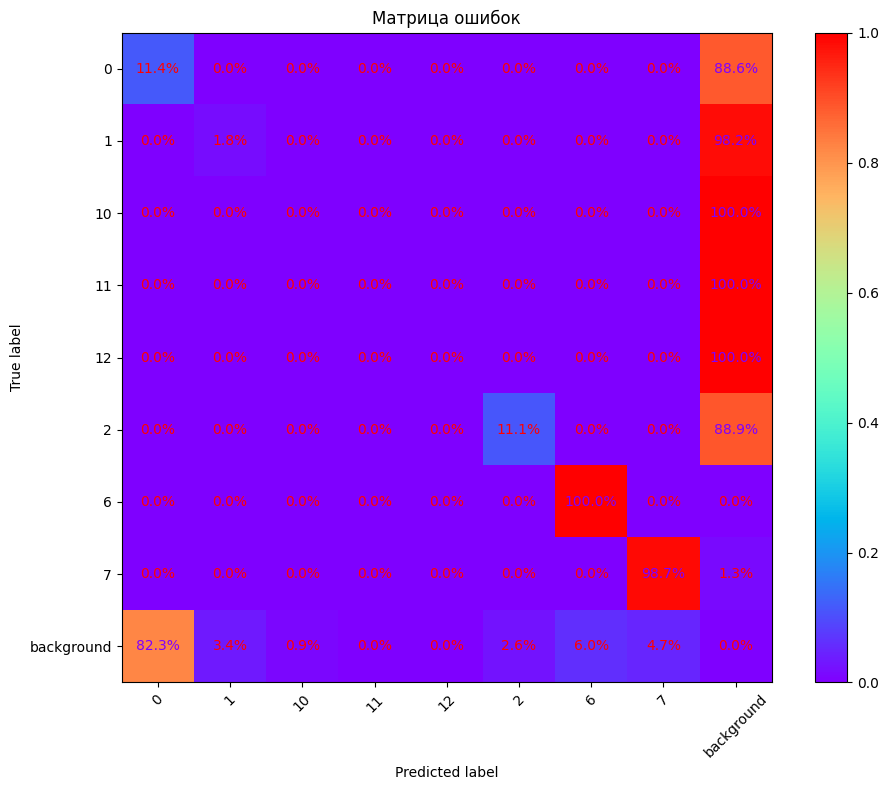

In [16]:
y_true, y_pred = [], []
for gt_cls, pred_dict in confusion_counts.items():
    for pred_cls, count in pred_dict.items():
        y_true.extend([gt_cls] * count)
        y_pred.extend([pred_cls] * count)

all_labels = sorted(set(y_true) | set(y_pred), key=lambda x: str(x))  # сортировка строковая для 'background'

# Нормализуем по строкам (т.е. на уровне каждого gt-класса)
cm = confusion_matrix(y_true, y_pred, labels=all_labels, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='rainbow', values_format='.1%', ax=ax)

plt.title("Матрица ошибок")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
import cv2
import numpy as np

def add_gaussian_noise(image, mean=0, sigma=3):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

image_path = '/kaggle/working/test_check/0-360-ls-r1-1-31he_0_0.png'
image = cv2.imread(image_path)

In [18]:
import matplotlib.pyplot as plt

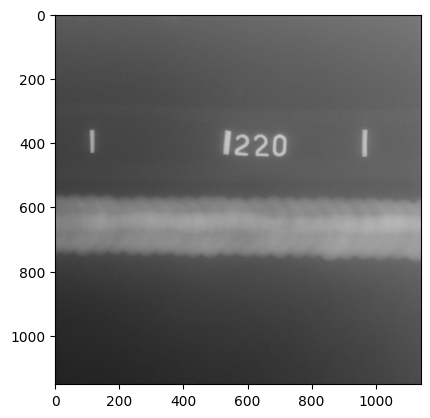

In [19]:
plt.imshow(image)

In [ ]:
plt.imshow(add_gaussian_noise(image, sigma=20))